In [1]:
import pickle
import torch
import numpy as np
import os 

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Process error data from a given filename and total time T.
def process_error_data(fname, T):
    with open(fname, "rb") as fp:
        info = pickle.load(fp)
    
    # Collect the training times of each model, use the first seed to extract training times
    model_times = []
    for t in range(len(info[0])):  # info[seed]
        t_i = info[0][t][0]  # info[seed][time_model][0]
        model_times.append(t_i)
    
    # Number of seeds (assuming each model has the same number of seeds)
    num_seeds = len(info)
    seed_errs = []
    times = []
    time_models = len(model_times)
    
    for t in range(time_models):
        t_i = model_times[t]
        if t < len(model_times) - 1:
            t_next = model_times[t + 1]
        else:
            t_next = T  # For the last model, extend to the total time T
        times_segment = list(range(t_i, t_next))
        times.extend(times_segment)
    
    # Process each seed to collect errors
    for seed in range(num_seeds):
        errs = []
        for t in range(time_models):
            t_i = model_times[t]
            if t < len(model_times) - 1:
                t_next = model_times[t + 1]
            else:
                t_next = T
    
            # Get the arr for this seed and time_model
            t_i_check, arr = info[seed][t]  # info[seed][time_model]
            assert t_i_check == t_i, f"Mismatch in training times: {t_i_check} != {t_i}"
    
            # Extract the error segment for the current model
            arr_segment = arr[t_i:t_next]
            errs.extend(arr_segment)
    
        seed_errs.append(errs)
    
    seed_errs = np.array(seed_errs)  # Shape: (num_seeds, total_time_length)
    
    mean = np.mean(seed_errs, axis=0)
    std = np.std(seed_errs, axis=0)
    
    return times, mean, std

In [2]:
T = 2000
# This checkpoint was trained from Rahul's version.

# python3 02_train.py net.type=prospective_mlp name='mlp_prospective' \
# tag=scenario2_v6 numseeds=5 ntest=100\
# tstart=20 tskip=100 tend=2021 dev='cuda:1'
fname = "./checkpoints/mlp_prospective_errs_v6.pkl"
pl_times, pl_inst_errors, pl_inst_std = process_error_data(fname, T)

In [3]:
def create_metrics(fnames, fout, model_names):

    infos = []
    for fname in fnames:
        with open(fname, "rb") as fp:
            info = pickle.load(fp)
        infos.append(info)

    plot_metrics = {}

    for model in range(len(infos)):
        seed_errs = []
        times = []

        for seed in range(len(infos[model])):
            info = infos[model][seed]

            errs = []
            for row in info:
                t, arr = row
                if seed == 0:
                    times.append(t)

                errs.append(np.mean(arr[t:]))
            seed_errs.append(errs)
        seed_errs = np.array(seed_errs)

        mean = np.mean(seed_errs, axis=0)
        std = np.std(seed_errs, axis=0)

        plot_metrics[model_names[model]] = np.array([mean, std, times])

    with open(fout, "wb") as fp:
        pickle.dump(plot_metrics, fp)

model_names_s2 = [ "Prospective"]
fnames_syn_s2 = ["./checkpoints/mlp_prospective_errs_v6.pkl"
                ]
fout_syn_s2 = "./metrics/syn_scenario2.pkl"
create_metrics(fnames_syn_s2,fout_syn_s2,model_names_s2)

info = np.load("./metrics/syn_scenario2.pkl", allow_pickle=True)
pl_plrisk,pl_plrisk_std,pl_plrisk_times = info['Prospective']

In [4]:
def online_sample_from_task_sequence(t, N=20):
    # Determine which task we are in at time t
    task = (t // N) % 2 + 1

    # Sample X from the uniform distribution on the set [-2, -1] U [1, 2]
    X = np.random.choice([-1, 1]) * (1 + np.random.rand())

    # Determine label Y based on the current task
    if task == 1:
        Y = np.sign(X)
    else:
        Y = -np.sign(X)

    return X, Y

def batch_sample_for_future_points(n, t, T, N=20, seed=1996):
    np.random.seed(seed)
    X = []
    Y = []

    for future_t in range(t, T):
        task = (future_t // N) % 2 + 1
        x_batch = np.random.choice([-1, 1], size=n) * (1 + np.random.rand(n))

        if task == 1:
            y_batch = np.sign(x_batch)
        else:
            y_batch = -np.sign(x_batch)

        X.append(x_batch)
        Y.append(y_batch)

    return np.array(X), np.array(Y)

In [5]:

file_path = './metrics/ogd.pkl'
N = 20
T = 2000
n_test = 50
n_reps = 50
k = 100  # New parameter for prospective error interval

# Ensure device is set to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define OGD loop function using PyTorch
def ogd_loop_torch():
    w = torch.randn(1, device=device, requires_grad=False)
    lr = 0.1
    ogd_error = []
    prospective_errors = []

    for t in range(1, T + 1):
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([x], device=device, dtype=torch.float32)
        y = torch.tensor([y], device=device, dtype=torch.float32)

        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32)

        # Make predictions and calculate current error
        with torch.no_grad():
            Y_hat = torch.sign(X_test @ w)
        ogd_error.append((Y_test != Y_hat).float().mean().item())

        # Calculate prospective errors every k steps
        if t % k == 0:
            # Obtain test samples for future evaluation from t to T
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32)

                with torch.no_grad():
                    Y_hat_future = torch.sign(X_future_test @ w)
                future_errors.append((Y_future_test != Y_hat_future).float().mean().item())

            prospective_errors.append(np.mean(future_errors))

        # Online gradient descent update
        with torch.no_grad():
            gradient = -y * x 
            w -= lr * gradient

    return ogd_error, prospective_errors

# Check if the file already exists
if not os.path.exists(file_path):
    # Running multiple repetitions and managing GPU memory
    ogd_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        ogd_error, prospective_errors = ogd_loop_torch()

        ogd_error_reps.append(torch.tensor(ogd_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())

        torch.cuda.empty_cache()

    ogd_error_reps = torch.stack(ogd_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    ogd_error = ogd_error_reps.mean(dim=0).numpy()
    ogd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_ogd = ogd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_ogd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5)

    # Save results to a pickle file
    with open(file_path, 'wb') as f:
        pickle.dump({
            'ogd_error': ogd_error,
            'ogd_prospective_error': ogd_prospective_error,
            'c_ogd': c_ogd,
            'c_ogd_prospective': c_ogd_prospective
        }, f)

# Code to read the saved pickle file
with open(file_path, 'rb') as f:
    results = pickle.load(f)

ogd_error = results['ogd_error']
ogd_prospective_error = results['ogd_prospective_error']
c_ogd = results['c_ogd']
c_ogd_prospective = results['c_ogd_prospective']

print("OGD Error:", ogd_error)
print("Prospective Error:", ogd_prospective_error)

OGD Error: [0.54 0.48 0.44 ... 0.44 0.44 0.6 ]
Prospective Error: [0.50526316 0.5        0.50588235 0.5        0.50666667 0.5
 0.50769231 0.5        0.50909091 0.5        0.51111111 0.5
 0.51428571 0.5        0.52       0.5        0.532      0.5
 0.596             nan]


In [6]:
ftl_file_path = './metrics/ftl.pkl'

# Define FTL loop function using PyTorch
def ftl_loop_torch(k):
    w = torch.randn(1, device=device)
    X_train = torch.empty((0, 1), device=device)
    Y_train = torch.empty((0,), device=device)

    ftl_error = []
    prospective_errors = []

    for t in range(1, T):
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([x], device=device, dtype=torch.float32).view(1, 1)
        y = torch.tensor([y], device=device, dtype=torch.float32).view(1)

        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test, device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test, device=device, dtype=torch.float32).view(-1)

        # Make predictions and calculate current error
        with torch.no_grad():
            Y_hat = torch.sign(X_test * w)
        Y_hat = Y_hat.view(-1)
        error = (Y_test != Y_hat).float().mean().item()
        ftl_error.append(error)

        # Only calculate prospective errors for t = k, 2k, 3k, ...
        if t % k == 0:
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32).view(-1)

                with torch.no_grad():
                    Y_hat_future = torch.sign(X_future_test * w)
                Y_hat_future = Y_hat_future.view(-1)
                future_error = (Y_future_test != Y_hat_future).float().mean().item()
                future_errors.append(future_error)

            prospective_errors.append(np.mean(future_errors))

        # Update training set
        X_train = torch.cat((X_train, x.view(1, 1)), dim=0)
        Y_train = torch.cat((Y_train, y), dim=0)

        # Check if we have enough samples to estimate means and variance
        if (Y_train == -1).sum() >= 5 and (Y_train == 1).sum() >= 5:
            m_0 = X_train[Y_train == -1].mean()
            m_1 = X_train[Y_train == 1].mean()

            # Compute variances for both classes (covariance is just variance in 1D)
            S_0 = X_train[Y_train == -1].var(unbiased=False) if (Y_train == -1).size(0) > 1 else torch.tensor(1.0, device=device)
            S_1 = X_train[Y_train == 1].var(unbiased=False) if (Y_train == 1).size(0) > 1 else torch.tensor(1.0, device=device)

            total_variance = S_0 + S_1
            if total_variance == 0:
                total_variance = torch.tensor(1.0, device=device)  # Avoid division by zero

            w = (m_1 - m_0) / total_variance
            w = w / torch.norm(w)

    return ftl_error, prospective_errors

# Check if the file already exists
if not os.path.exists(ftl_file_path):
    ftl_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        ftl_error, prospective_errors = ftl_loop_torch(k)
        
        ftl_error_reps.append(torch.tensor(ftl_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())
        
        torch.cuda.empty_cache()

    ftl_error_reps = torch.stack(ftl_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    ftl_error = ftl_error_reps.mean(dim=0).numpy()
    ftl_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_ftl = ftl_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_ftl_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    with open(ftl_file_path, 'wb') as f:
        pickle.dump({
            'ftl_error': ftl_error,
            'ftl_prospective_error': ftl_prospective_error,
            'c_ftl': c_ftl,
            'c_ftl_prospective': c_ftl_prospective
        }, f)
        
with open(ftl_file_path, 'rb') as f:
    ftl_results = pickle.load(f)

# Access the saved data
ftl_error = ftl_results['ftl_error']
ftl_prospective_error = ftl_results['ftl_prospective_error']
c_ftl = ftl_results['c_ftl']
c_ftl_prospective = ftl_results['c_ftl_prospective']

In [7]:
lr = 0.01
bgd_file_path  = './metrics/bgd.pkl'

# Bayesian Gradient Descent (BGD) Loop
def bgd_loop_torch():
    mu = torch.randn(1, device=device, requires_grad=True)
    log_sigma = torch.zeros(1, device=device, requires_grad=True)  # optimize log variance for numerical stability

    bgd_error = []
    prospective_errors = []
    optimizer = torch.optim.Adam([mu, log_sigma], lr=lr)

    for t in range(1, T + 1):
        x, y = online_sample_from_task_sequence(t, N)
        x = torch.tensor([x], device=device, dtype=torch.float32)
        y = torch.tensor([y], device=device, dtype=torch.float32)

        # Sample w from the current posterior
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        w = mu + sigma * eps

        # Negative log-likelihood loss (we use logistic loss for classification)
        loss = torch.nn.functional.softplus(-y * (w * x)).mean()

        # KL divergence between posterior and prior (assuming standard normal prior)
        kl_divergence = 0.5 * (mu.pow(2) + sigma.pow(2) - 2 * log_sigma - 1).sum()

        # Total loss is the sum of negative log-likelihood and KL divergence
        total_loss = loss + kl_divergence

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # For prediction, use the mean weight (mu)
        X_test, Y_test = batch_sample_for_future_points(n_test, t, t + 1, N)
        X_test = torch.tensor(X_test[0], device=device, dtype=torch.float32).view(-1, 1)
        Y_test = torch.tensor(Y_test[0], device=device, dtype=torch.float32)

        with torch.no_grad():
            Y_hat = torch.sign(X_test * mu)
        Y_hat = Y_hat.view(-1)
        error = (Y_test != Y_hat).float().mean().item()
        bgd_error.append(error)

        # Calculate prospective errors every k steps
        if t % k == 0:
            X_future, Y_future = batch_sample_for_future_points(n_test, t, T, N)
            future_errors = []

            for future_idx in range(len(X_future)):
                X_future_test = torch.tensor(X_future[future_idx], device=device, dtype=torch.float32).view(-1, 1)
                Y_future_test = torch.tensor(Y_future[future_idx], device=device, dtype=torch.float32)

                with torch.no_grad():
                    Y_hat_future = torch.sign(X_future_test * mu)
                Y_hat_future = Y_hat_future.view(-1)
                future_error = (Y_future_test != Y_hat_future).float().mean().item()
                future_errors.append(future_error)

            prospective_errors.append(np.mean(future_errors))

    return bgd_error, prospective_errors

# Check if the file already exists
if not os.path.exists(bgd_file_path):
    bgd_error_reps = []
    prospective_error_reps = []

    for _ in range(n_reps):
        bgd_error, prospective_errors = bgd_loop_torch()

        bgd_error_reps.append(torch.tensor(bgd_error).cpu())
        prospective_error_reps.append(torch.tensor(prospective_errors).cpu())
        torch.cuda.empty_cache()

    bgd_error_reps = torch.stack(bgd_error_reps)
    prospective_error_reps = torch.stack(prospective_error_reps)

    bgd_error = bgd_error_reps.mean(dim=0).numpy()
    bgd_prospective_error = prospective_error_reps.mean(dim=0).numpy()
    c_bgd = bgd_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96
    c_bgd_prospective = prospective_error_reps.std(dim=0).numpy() / (n_reps ** 0.5) * 1.96

    with open(bgd_file_path, 'wb') as f:
        pickle.dump({
            'bgd_error': bgd_error,
            'bgd_prospective_error': bgd_prospective_error,
            'c_bgd': c_bgd,
            'c_bgd_prospective': c_bgd_prospective
        }, f)
    
with open(bgd_file_path, 'rb') as f:
    bgd_results = pickle.load(f)

# Access the saved data
bgd_error = bgd_results['bgd_error']
bgd_prospective_error = bgd_results['bgd_prospective_error']
c_bgd = bgd_results['c_bgd']
c_bgd_prospective = bgd_results['c_bgd_prospective']

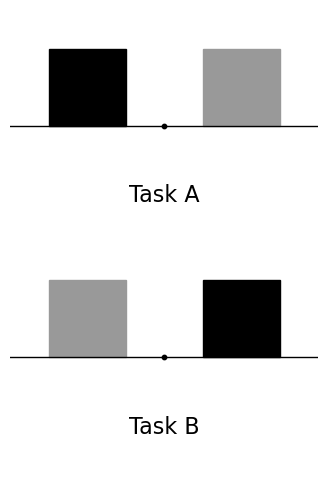

In [8]:
def plot_task(ax, task_name, y_offset, colors, fontsize):
    ax.add_patch(Rectangle((-1.5, y_offset), 1, 1, color=colors[0], alpha=1))  # Left rectangle
    ax.add_patch(Rectangle((0.5, y_offset), 1, 1, color=colors[1], alpha=1))   # Right rectangle
    ax.scatter(0, y_offset, color='black', s=10)  # Center point

    ax.set_xlim([-2, 2])
    ax.set_ylim([-3, 3])

    ax.set_xticks([])
    ax.set_yticks([])

    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.axhline(y=y_offset, color='black', linewidth=1)
    ax.set_aspect('equal')
    ax.text(0, y_offset - 1, task_name, fontsize=fontsize, ha='center')

fig, main_ax = plt.subplots(figsize=(8, 6))

colors_task_A = ['#000000', '#999999']  # Black on the left, gray on the right
colors_task_B = ['#999999', '#000000']  # Gray on the left, black on the right

plot_task(main_ax, 'Task A', 1.5, colors_task_A, 16)  # Task A with y_offset=1.5
plot_task(main_ax, 'Task B', -1.5, colors_task_B, 16)  # Task B with y_offset=-1.5

plt.show()

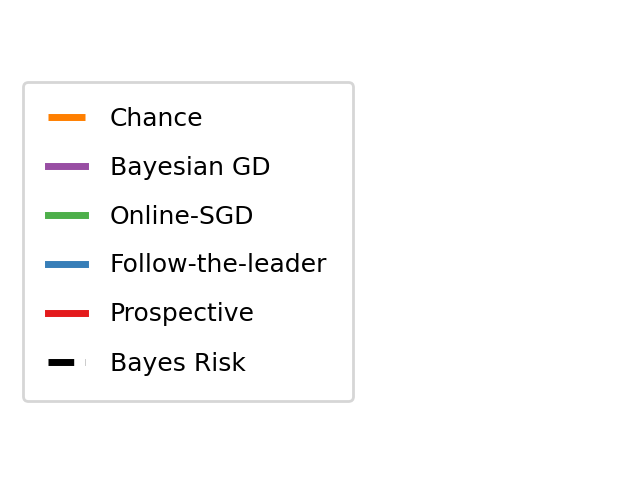

In [9]:
def plot_legend(ax, fontsize):
    colors = {'Chance': '#ff7f00', 'Bayesian GD': '#984ea3', 'Online-SGD': '#4daf4a', 
            'Follow-the-leader': '#377eb8', 'Prospective': '#e41a1c', 'Bayes Risk': 'black'}

    linestyles = {'Chance': '-.', 'Bayesian GD': '-', 'Online-SGD': '-', 
                'Follow-the-leader': '-', 'Prospective': '-', 'Bayes Risk': '--'}

    for label, color in colors.items():
        ax.plot([], [], color=color, linestyle=linestyles[label], label=label, linewidth=5)

    legend = ax.legend(frameon=True, loc='center left', ncol=1, fontsize=fontsize, handlelength=1.5, handletextpad=1, borderpad=1, labelspacing=1)

    legend.get_frame().set_linewidth(2)  

    ax.axis('off')

fig, main_ax = plt.subplots(figsize=(8, 6))
plot_legend(main_ax, 18)


In [10]:
# Based on Rahul's code and data, integrate the MNIST and CIFAR figures into the overall Figure 2
def make_plot1(info, title, figname, ax, fontsize, size=50, plot_index=None, subsample=None,
              outside_legend=False, minimal=False, discount=False):
    ax.set_ylim([-0.05, 1])
    ax.set_title(title, fontsize=fontsize)

    cols = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3',
            '#ff7f00', '#ffff33', '#a65628']

    methods = []
    methods_legend = []
    for m in info:
        methods.append(m)
        # print(m)
        if m == 'ERM':
            methods_legend.append('Follow-the-leader')
        else:
            methods_legend.append(m)

    ax.set_ylabel("Prospective Risk", fontsize=fontsize)
    ax.set_xlabel("Time (t)", fontsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)

    if plot_index is not None:
        methods = [methods[i] for i in plot_index]

    if subsample is not None:
        for m, s in subsample:
            info[methods[m]]= info[methods[m]][:,::s]
    for i, m in enumerate(methods):
        ax.plot(info[m][2], info[m][0], c=cols[i])

    # plot chance risk
    if "syn" in figname:
        ax.axhline(y=0.5, color='#ff7f00', linestyle='--', linewidth=5)
    elif "mnist" or "cifar" in figname:
        ax.axhline(y=0.742, color='#ff7f00', linestyle='--', linewidth=5)

    for i, m in enumerate(methods):
        print(m)
        ax.scatter(info[m][2], info[m][0], c=cols[i], s=size, linewidth=5)
        std = 2 * info[m][1] / np.sqrt(5)
        mean = info[m][0]
        ax.fill_between(info[m][2], mean-std, mean+std,
                         alpha=0.3, color=cols[i])

ERM
Prospective
Online-SGD
Bayesian GD


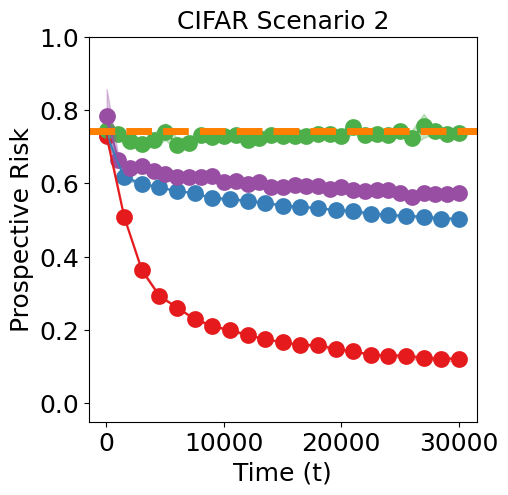

In [11]:
def mnist_scenario2(ax, fontsize):
    info = np.load("./metrics/mnist_scenario2.pkl", allow_pickle=True)
    make_plot1(info, "MNIST Scenario 2", figname="mnist_scenario2", ax=ax, fontsize=fontsize, minimal=True)

def cifar_scenario2(ax, fontsize):
    info = np.load("./metrics/cifar_scenario2.pkl", allow_pickle=True)
    make_plot1(info, "CIFAR Scenario 2", figname="cifar_scenario2",ax=ax, fontsize=fontsize,
                plot_index=[0, 1, 2, 3], subsample=[(2, 2), (3, 2)], minimal=True)

fig, main_ax = plt.subplots(figsize=(5, 5))
cifar_scenario2(main_ax, 18)

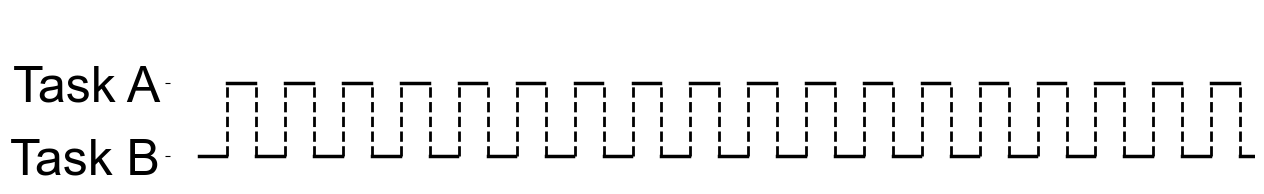

In [12]:
def plot_task_excuting(start_time, end_time, N, fontsize, ax):
    times = np.arange(start_time,end_time,1)
    task1_y = np.zeros_like(times)
    task2_y = np.ones_like(times)

    # Plot solid lines for tasks
    for i in range(start_time+N, end_time, 2*N):
        ax.plot(times[i:i+N], task1_y[i:i+N], color='black', lw=2.5, label='Task 1' if i == 0 else "")
        ax.plot(times[i+N:i+2*N], task2_y[i+N:i+2*N], color='black', lw=2.5, label='Task 2' if i == 0 else "")

    # Plot dashed lines to indicate task switches
    for i in range(start_time+2*N, end_time, N):
        ax.plot([i, i], [0, 1], color='black', linestyle='dashed', lw=2)

    # Customize the plot
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Task B', 'Task A'], fontsize=fontsize)
    ax.set_xticks([])
    ax.set_xlim([start_time, end_time])
    ax.set_ylim([-0.1, 2])
    ax.set_frame_on(False) 
    ax.grid(False)
    
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_palette('pastel')

fig, main_ax = plt.subplots(figsize=(14, 2))
plot_task_excuting(0, 750, 20, 36, main_ax)

ERM
Prospective
Online-SGD
Bayesian GD
ERM
Prospective
Online-SGD
Bayesian GD


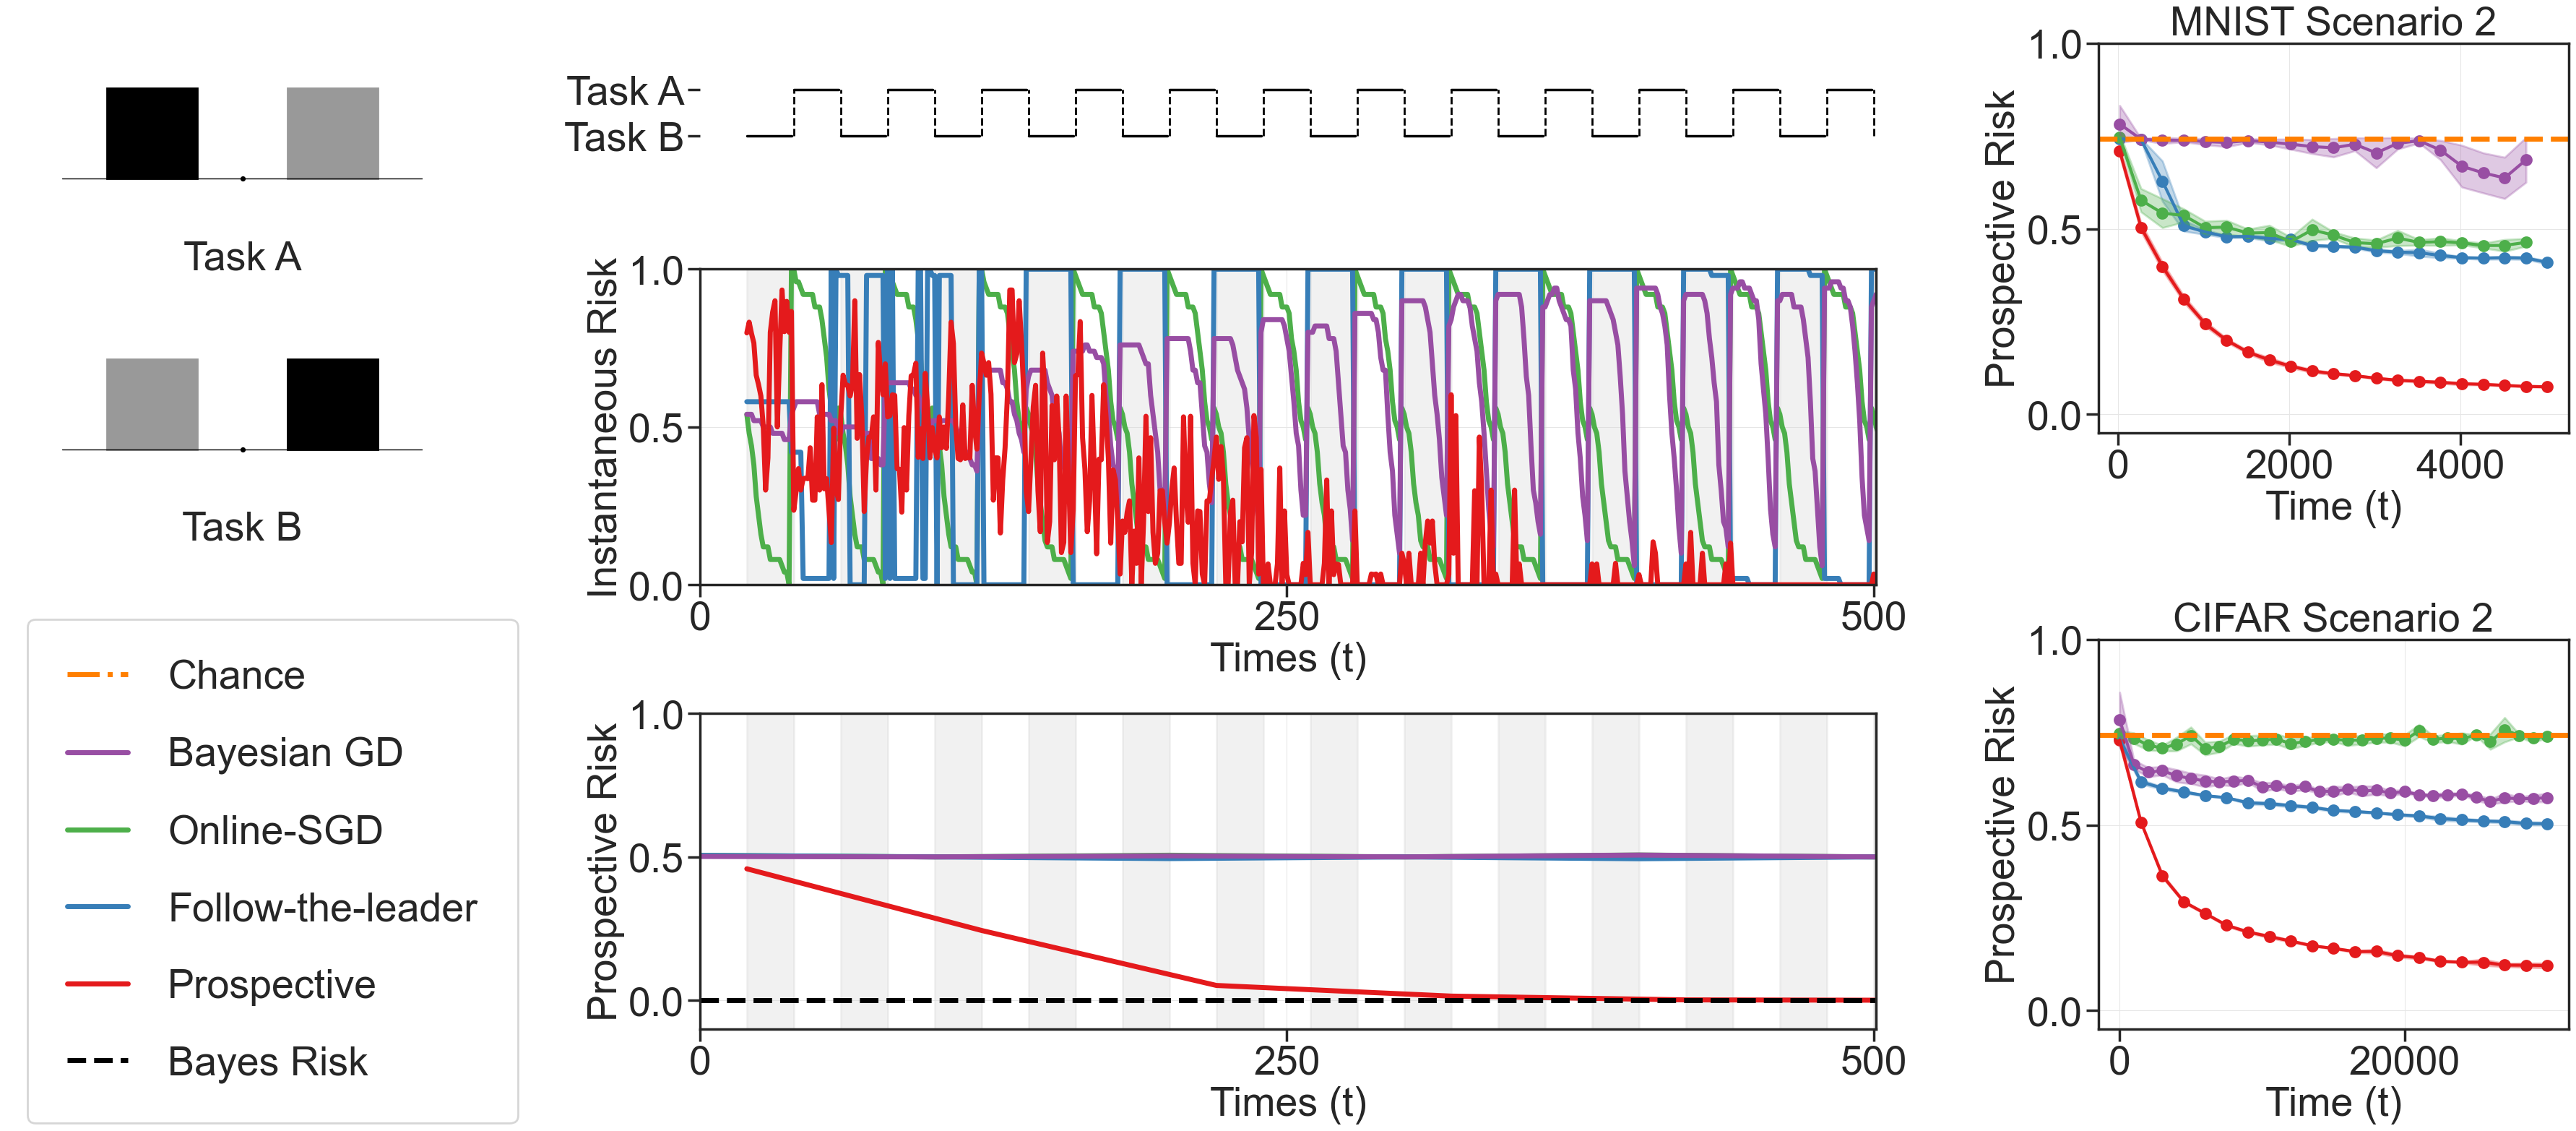

In [13]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
colors = {'OGD': '#4daf4a', 'FTL': '#377eb8', 'Prospective MLP': '#e41a1c','BGD':'#984ea3'}
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(context='poster',
        style='ticks',
        font_scale=.75,
        rc={'axes.grid': True,
            'grid.color': '.9',
            'grid.linewidth': 0.75})

start_time = 0
end_time = 501
stepsz = 1
N = 20
fontsize=40

fig = plt.figure(figsize=(36, 16))
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 2.5, 1], height_ratios=[2, 6.5, 6.5])

# First column
axes = {}
axes['left1'] = fig.add_subplot(gs[0:2, 0])  # 'left1' spans rows 0 and 1 in column 0
axes['left2'] = fig.add_subplot(gs[2, 0])    # 'left2' in row 2, column 0

# Second column
axes['right1'] = fig.add_subplot(gs[0, 1])   # 'right1' in row 0, column 1
axes['right2'] = fig.add_subplot(gs[1, 1])   # 'right2' in row 1, column 1
axes['right3'] = fig.add_subplot(gs[2, 1])   # 'right3' in row 2, column 1

# Third column: Nested GridSpec to split the space equally between 'right4' and 'right5'
gs_right_col = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[:, 2])

axes['right4'] = fig.add_subplot(gs_right_col[0])  # Upper half of third column
axes['right5'] = fig.add_subplot(gs_right_col[1])  # Lower half of third column

plt.subplots_adjust(wspace=0.1, hspace=0.15)

x, y = np.mgrid[-2:2:.1, -2:2:.1]
ax1 = axes['left1']
# Define colors for Task A and Task B
colors_task_A = ['#000000', '#999999']  # Black on the left, gray on the right
colors_task_B = ['#999999', '#000000']  # Gray on the left, black on the right

# Plot Task A at y_offset = 1.5 and Task B at y_offset = -1.5
plot_task(ax1, 'Task A', 1.5, colors_task_A, fontsize)  # Task A with y_offset=1.5
plot_task(ax1, 'Task B', -1.5, colors_task_B, fontsize)  # Task B with y_offset=-1.5

plot_legend(axes['left2'], fontsize)
plot_task_excuting(start_time, end_time, N, fontsize, axes['right1'])

ax = axes['right2']
ax.plot(pl_times[start_time:end_time:stepsz], ogd_error[start_time:end_time:stepsz],lw=5,c=colors['OGD'], label='OGD')
ax.plot(pl_times[start_time:end_time:stepsz], ftl_error[start_time:end_time:stepsz], lw=5,c=colors['FTL'], label='FTL')
ax.plot(pl_times[start_time:end_time:stepsz], bgd_error[start_time:end_time:stepsz], lw=5,c=colors['BGD'], label='BGD')
ax.plot(pl_times[::stepsz], pl_inst_errors[::stepsz], c=colors['Prospective MLP'], lw=5,label='Prospective MLP')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Instantaneous Risk", fontsize=fontsize)

ax.set_xlim(start_time, end_time)
ax.set_xticks([0, 250, 500])
ax.set_xticklabels(['0', '250','500'], fontsize=fontsize)
ax.set_ylim([-0., 1])
ax.tick_params(axis='y', labelsize=fontsize)

ax = axes['right3']
ax.plot(np.arange(start_time,end_time+k,k), ogd_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['OGD'], label='OGD')
ax.plot(np.arange(start_time,end_time+k,k), ftl_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['FTL'], label='Follow-the-leader')
ax.plot(np.arange(start_time,end_time+k,k), bgd_prospective_error[int(start_time/k):int(end_time/k)+2], lw=5, c=colors['BGD'], label='Bayesian GD')
ax.plot(pl_plrisk_times[:], pl_plrisk[:], lw=5,c=colors['Prospective MLP'], label='Prospective')
ax.axhline(y=0, color='black', lw=5,linestyle='--',label='Bayes Risk')
ax.set_xlabel("Times (t)", fontsize=fontsize)
ax.set_ylabel("Prospective Risk", fontsize=fontsize)
ax.set_xlim(start_time, end_time)

ax.set_xticks([0, 250, 500])
ax.set_xticklabels(['0', '250','500'], fontsize=fontsize)
ax.set_ylim([-0.1, 1])
ax.set_yticks([0, 0.5, 1])
ax.tick_params(axis='y', labelsize=fontsize)

for i in range(start_time, end_time, N*2):
    task_b_start = i + N  # Task B starts after Task A
    task_b_end = i + 2 * N  # Task B ends after its 20-second interval

    # Add shading for Task B execution intervals
    axes['right2'].fill_betweenx([-0.1, 1.1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    axes['right3'].fill_betweenx([-0.1, 1], task_b_start, task_b_end, color='lightgray', alpha=0.3)
    
mnist_scenario2(axes['right4'],fontsize)
cifar_scenario2(axes['right5'],fontsize)

plt.plot()
plt.tight_layout()
plt.savefig("./figures/overall_scenario2_perceptron.pdf", format="pdf", bbox_inches="tight")

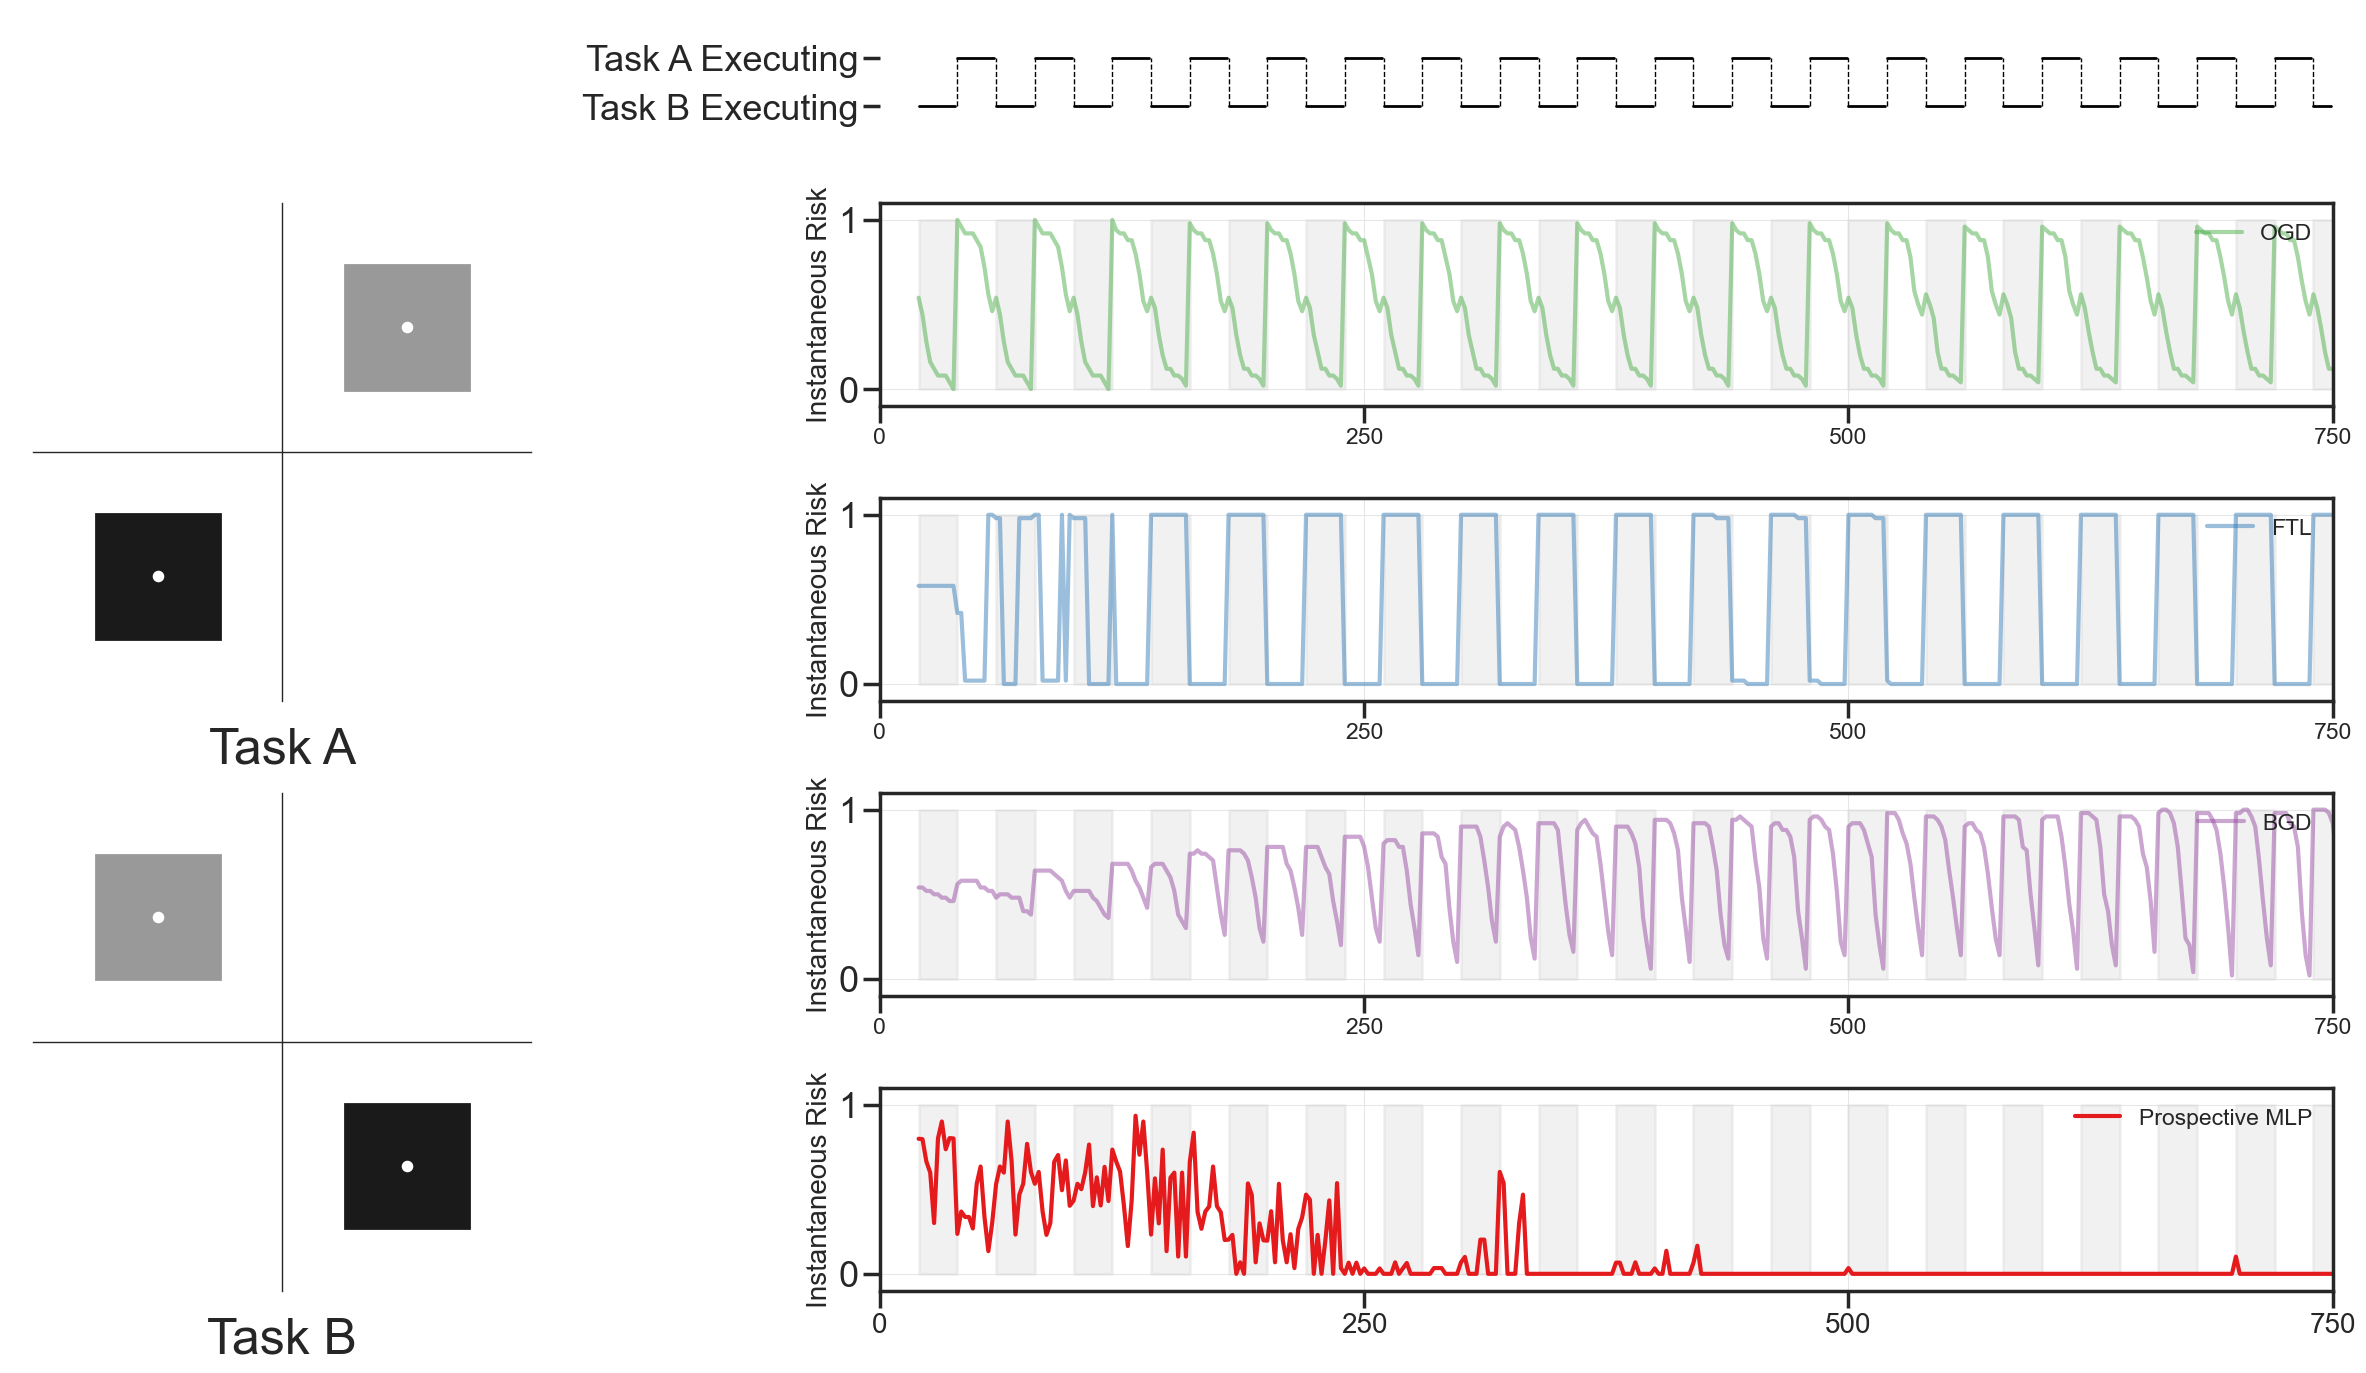

In [14]:
colors = {'OGD': '#4daf4a', 'FTL': '#377eb8', 'Prospective MLP': '#e41a1c','BGD':'#984ea3'}
plt.style.use("seaborn-v0_8-whitegrid")
sns.set(context='poster',
        style='ticks',
        font_scale=.75,
        rc={'axes.grid': True,
            'grid.color': '.9',
            'grid.linewidth': 0.75})

start_time = 0
end_time = 750
stepsz = 2
N = 20

fig, axes = plt.subplot_mosaic(
    [['space1', 'right1'],
     ['left1', 'right2'],
     ['left1', 'right3'],
     ['left2', 'right4'],
     ['left2', 'right5']],
    figsize=(24, 14),
    width_ratios=[1.5, 4],  # Adjusted to give more width to the left panels
    height_ratios=[1, 2, 2, 2, 2]
)

plt.subplots_adjust(wspace=0, hspace=0.3)

# Disable grid and axes for the 'space' subplot
ax1 = axes['space1']
ax1.grid(False)
ax1.axis('off')

# Plot for Task A in 'left1' (larger left panel)
x, y = np.mgrid[-2:2:.1, -2:2:.1]
ax1 = axes['left1']
ax1.add_patch(Rectangle((-1.5, -1.5), 1, 1, color='k', alpha=1, label='Task A: sign of sample'))
ax1.add_patch(Rectangle((0.5, 0.5), 1, 1, color='#999999', alpha=1))
ax1.scatter([0, 1, -1], [0, 1, -1], c='w', s=40)
ax1.set_xlim([-2, 2])
ax1.set_ylim([-2, 2])
ax1.set_aspect("equal")
ax1.set_xticks([])
ax1.set_yticks([])
for spine in ['left', 'bottom']:
    ax1.spines[spine].set_position('zero')
    ax1.spines[spine].set_linewidth(1)
ax1.spines['right'].set_color('none')
ax1.spines['top'].set_color('none')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.text(0, -2.5, 'Task A', fontsize=36, ha='center')

# Plot for Task B in 'left2' (larger left panel)
ax2 = axes['left2']
ax2.add_patch(Rectangle((-1.5, 0.5), 1, 1, color='#999999', alpha=1))
ax2.add_patch(Rectangle((0.5, -1.5), 1, 1, color='k', alpha=1))
ax2.scatter([0, 1, -1], [0, -1, 1], c='w', s=40)
ax2.set_xlim([-2, 2])
ax2.set_ylim([-2, 2])
ax2.set_aspect("equal")
ax2.set_xticks([])
ax2.set_yticks([])
for spine in ['left', 'bottom']:
    ax2.spines[spine].set_position('zero')
    ax2.spines[spine].set_linewidth(1)
ax2.spines['right'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_ticks_position('left')
ax2.text(0, -2.5, 'Task B', fontsize=36, ha='center')

# Plot the task schedule in 'right1'
ax = axes['right1']
times = np.arange(start_time, end_time, 1)
task1_y = np.zeros_like(times)
task2_y = np.ones_like(times)
for i in range(start_time + N, end_time, 2 * N):
    ax.plot(times[i:i + N], task1_y[i:i + N], color='black', lw=2, label='Task 1' if i == start_time + N else "")
    ax.plot(times[i + N:i + 2 * N], task2_y[i + N:i + 2 * N], color='black', lw=2, label='Task 2' if i == start_time + N else "")
    ax.plot([i + N, i + N], [0, 1], color='black', linestyle='dashed', lw=1)
    ax.plot([i + 2*N, i +2* N], [0, 1], color='black', linestyle='dashed', lw=1)
ax.set_yticks([0, 1])
ax.set_yticklabels(['Task B Executing', 'Task A Executing'], fontsize=26)
ax.set_xticks([])
ax.set_xlim([start_time, end_time])
ax.set_ylim([-0.1, 2])
ax.set_frame_on(False)
ax.grid(False)

sns.set_style("white")
sns.set_style("ticks")
sns.set_palette('pastel')

# Plot OGD error in 'right2'
ax = axes['right2']
ax.plot(pl_times[start_time:end_time:stepsz], ogd_error[start_time:end_time:stepsz], c=colors['OGD'], label='OGD', alpha=0.5)
ax.set_ylabel("Instantaneous Risk", fontsize=20)
ax.set_xlim(start_time, end_time)
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 250, 500, 750])
ax.tick_params(axis='y', labelsize=26)
ax.legend(loc='upper right')

# Plot FTL error in 'right3'
ax = axes['right3']
ax.plot(pl_times[start_time:end_time:stepsz], ftl_error[start_time:end_time:stepsz], c=colors['FTL'], label='FTL', alpha=0.5)
ax.set_ylabel("Instantaneous Risk", fontsize=20)
ax.set_xlim(start_time, end_time)
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 250, 500, 750])
ax.tick_params(axis='y', labelsize=26)
ax.legend(loc='upper right')

# Plot BGD error in 'right4'
ax = axes['right4']
ax.plot(pl_times[start_time:end_time:stepsz], bgd_error[start_time:end_time:stepsz], c=colors['BGD'], label='BGD', alpha=0.5)
ax.set_ylabel("Instantaneous Risk", fontsize=20)
ax.set_xlim(start_time, end_time)
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 250, 500, 750])
ax.tick_params(axis='y', labelsize=26)
ax.legend(loc='upper right')

# Plot Prospective MLP error in 'right5'
ax = axes['right5']
ax.plot(pl_times[::stepsz], pl_inst_errors[::stepsz], c=colors['Prospective MLP'], label='Prospective MLP')
ax.set_ylabel("Instantaneous Risk", fontsize=20)
ax.set_xlim(start_time, end_time)
ax.set_ylim([-0.1, 1.1])
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250', '500', '750'], fontsize=20)
ax.tick_params(axis='y', labelsize=26)
ax.legend(loc='upper right')

# Apply fill_between to all algorithm plots
for i in range(start_time, end_time, N * 2):
    task_b_start = i + N
    task_b_end = i + 2 * N
    for key in ['right2', 'right3', 'right4', 'right5']:
        axes[key].fill_betweenx([0, 1], task_b_start, task_b_end, color='lightgray', alpha=0.3)

plt.tight_layout()